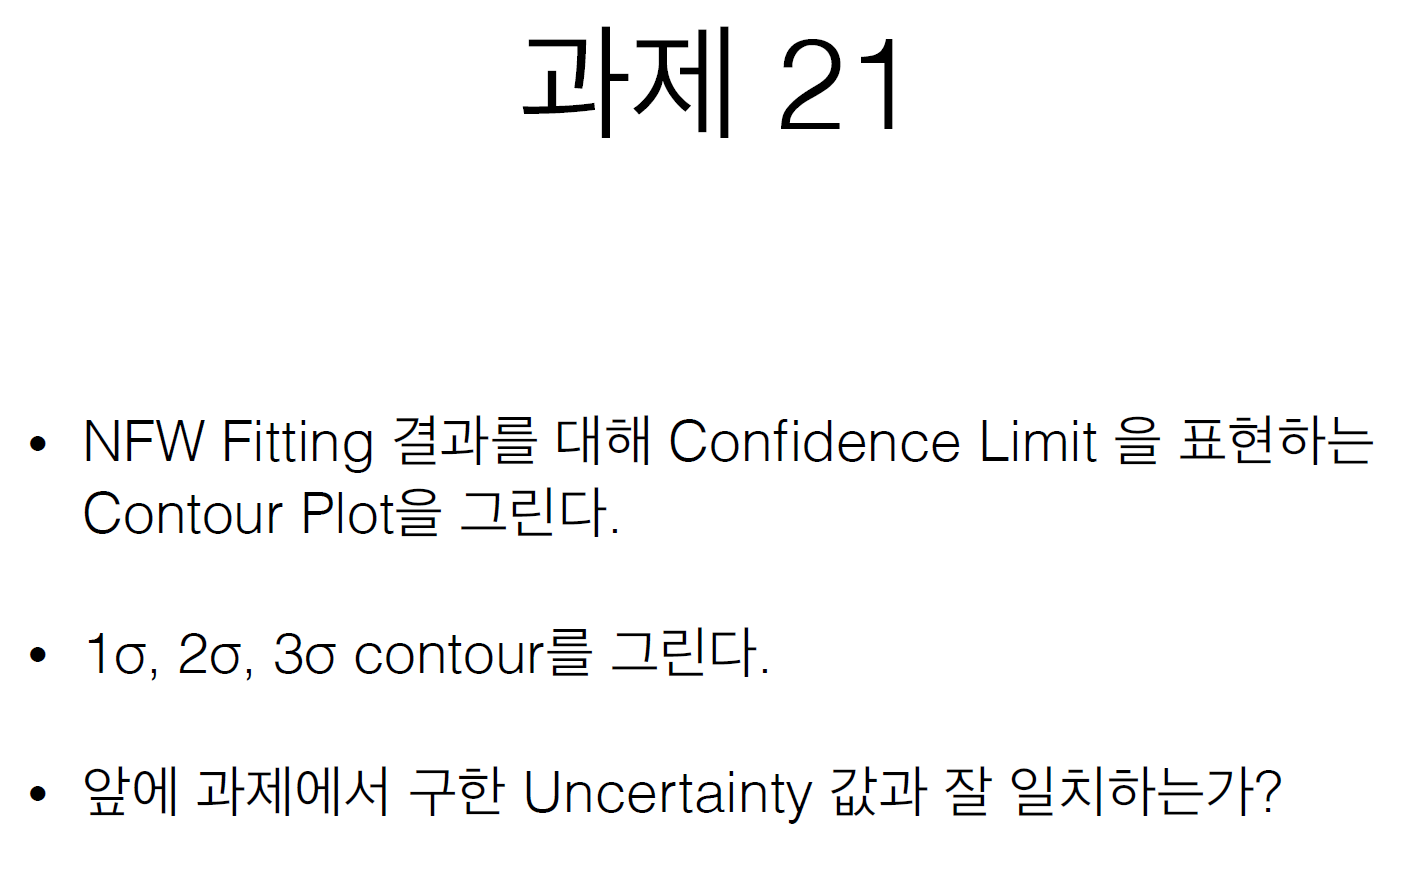

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from matplotlib.colors import LogNorm

In [70]:
def chi2_func(params, r, rho, rho_err, function):
    chi_value = function(params, r, rho, rho_err)
    return np.sum(((chi_value - rho)/rho_err)**2)

def NFW(params, r, rho, rho_err):
    rho0, rs = params
    return rho0 / (r/rs * (1 + r/rs)**2)

def uncert_1d(func, x, args, h=1e-5):
    result = (func(x + h, *args) - 2 * func(x, *args) + func(x - h, *args)) / (h**2)
    return np.sqrt(result**-1)

def gradient(func, x, args, h=1e-4):
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        f_x_plux_h = func(x, *args)
        
        x[idx] = tmp
        fx = func(x, *args)
        
        grad[idx] = (f_x_plux_h - fx) / h
        x[idx] = tmp
    return grad

def hessian(func, x, args, h=1e-4):
    hess = np.zeros_like((x, x))
    x_n = x.copy()
    
    for idx in range(x.size):
        x_n[idx] = x[idx] + h
        df_x_plux_h = gradient(func, x_n, args)
        
        df_x = gradient(func, x, args)
        
        hess[:, idx] = (df_x_plux_h - df_x) / h
        x_n = x.copy()
    return hess

def uncert_2d(func, x, args, h=1e-4):
    hess = hessian(func, x, args, h)
    return np.sqrt(np.diag(np.linalg.inv(hess)))

def reduced_chi2_func(func, params, args):
    model = func(params, *args)
    chi = np.sum(((model - args[1])/args[2])**2)
    freedom = len(args[0]) - len(params)
    return chi / freedom

In [71]:
halo = pd.read_csv('halo.dat', names=['r', 'rho', 'rho_err'], sep=r'\s+')

In [72]:
result_nfw_ds = opt.minimize(
    chi2_func,
    x0=[0.1, 0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], NFW),
    method='Nelder-Mead'
);uncert_nfw_ds = uncert_2d(chi2_func, result_nfw_ds.x, (halo['r'], halo['rho'], halo['rho_err'], NFW))

result_nfw_po = opt.minimize(
    chi2_func,
    x0=[0.1, 0.1],
    args=(halo['r'], halo['rho'], halo['rho_err'], NFW),
    method='Powell'
);uncert_nfw_po = uncert_2d(chi2_func, result_nfw_po.x, (halo['r'], halo['rho'], halo['rho_err'], NFW))

rchi_nfw_ds = reduced_chi2_func(NFW, result_nfw_ds.x, (halo['r'], halo['rho'], halo['rho_err']))
rchi_nfw_po = reduced_chi2_func(NFW, result_nfw_po.x, (halo['r'], halo['rho'], halo['rho_err']))
chi_nfw_ds = chi2_func(result_nfw_ds.x, halo['r'], halo['rho'], halo['rho_err'], NFW)
chi_nfw_po = chi2_func(result_nfw_po.x, halo['r'], halo['rho'], halo['rho_err'], NFW)

In [73]:
print(f"result NFW: {result_nfw_ds.x}")
print(f"uncertainty: {uncert_nfw_ds}")
print(f"reduced chi2: {rchi_nfw_ds}")
print(f"chi2: {chi_nfw_ds}")

result NFW: [ 1.10738994 14.92837808]
uncertainty: [0.11549162 0.64219482]
reduced chi2: 1.2234822043042866
chi2: 119.90125602182007


In [74]:
posterior = np.exp(-0.5 * chi2_func(result_nfw_ds.x, halo['r'], halo['rho'], halo['rho_err'], NFW))
print(f"posterior: {posterior}")

posterior: 9.19968735135523e-27


In [75]:
posteriors = []
for idx in range(3):
    X_2 = np.sum(((halo['rho'] - NFW(result_nfw_ds.x, halo['r'], halo['rho'], halo['rho_err'])) / (idx + 1) * halo['rho_err'])**2)
    posteriors.append(np.exp(-0.5 * X_2))

In [87]:
X, Y = np.meshgrid(
    np.linspace(result_nfw_ds.x[0] - 4 * uncert_nfw_ds[0], result_nfw_ds.x[0] + 4 * uncert_nfw_ds[0], 100),
    np.linspace(result_nfw_ds.x[1] - 4 * uncert_nfw_ds[1], result_nfw_ds.x[1] + 4 * uncert_nfw_ds[1], 100)
)
z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z[i, j] = chi2_func([X[i, j], Y[i, j]], halo['r'], halo['rho'], halo['rho_err'], NFW)

In [108]:
res_chi = chi2_func(result_nfw_ds.x + uncert_nfw_po, halo['r'], halo['rho'], halo['rho_err'], NFW)

In [89]:
from scipy.stats import chi2
from matplotlib.patches import Ellipse

Hessian uncertainty: [0.11549162 0.64219482]


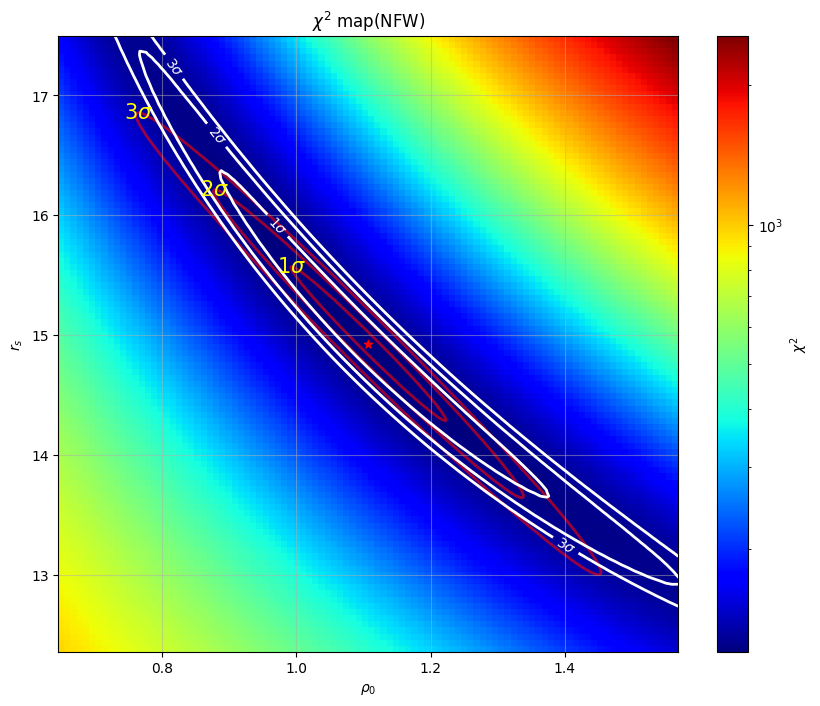

In [132]:
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.5)
plt.imshow(
    z,
    norm=LogNorm(),
    extent=(X.min(), X.max(), Y.min(), Y.max()),
    origin='lower',
    cmap='jet',
    aspect='auto'
)
plt.xlabel(r'$\rho_0$'); plt.ylabel(r'$r_s$')
plt.title(r'$\chi^2$' + " map(NFW)")
plt.colorbar(label=r'$\chi^2$')
#------------------------------------------------------------------------------------------------------
plt.scatter(result_nfw_ds.x[0], result_nfw_ds.x[1], color='red', label='fitting result', marker='*')
#------------------------------------------------------------------------------------------------------
max_post = np.max(z)
sigmas = [chi2.ppf(0.68, df=2), chi2.ppf(0.95, df=2), chi2.ppf(0.99, df=2)]
levs = [chi_nfw_ds + sigmas[0], chi_nfw_ds + sigmas[1], chi_nfw_ds + sigmas[2]]
tags = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
cs = plt.contour(X, Y, z, levels=levs, colors='white', linewidths=2)
plt.clabel(cs, inline=True, fontsize=10, fmt={levs[0]: tags[0], levs[1]: tags[1], levs[2]: tags[2]})
#------------------------------------------------------------------------------------------------------
# 최적점에서 Hessian 계산
hess = hessian(chi2_func, result_nfw_ds.x, (halo['r'], halo['rho'], halo['rho_err'], NFW))
cov_hess = np.linalg.inv(hess)
uncert_hess = np.sqrt(np.diag(cov_hess))

print("Hessian uncertainty:", uncert_hess)

vals, vecs = np.linalg.eigh(cov_hess)
order = vals.argsort()[::-1]
vals, vecs = vals[order], vecs[:, order]
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

for nsig, color, tag in zip([1,2,3], ['red','red','red'], [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']):
    width, height = 2 * nsig * np.sqrt(vals)
    ellipse = Ellipse(
        (result_nfw_ds.x[0], result_nfw_ds.x[1]), width, height, angle=theta,
        edgecolor=color, fc='None', lw=2, alpha=0.6
    )
    plt.gca().add_patch(ellipse)
    angle_rad = np.radians(theta)
    x_tag = result_nfw_ds.x[0] + (width/2) * np.cos(angle_rad)
    y_tag = result_nfw_ds.x[1] + (width/2) * np.sin(angle_rad)
    plt.gca().text(
        x_tag, y_tag, tag, color='yellow', fontsize=15, weight='bold',
        va='center', ha='center'
    )